In [9]:
import meep as mp
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

n = 1.4440
w = 2
r = 1
pad = 4
dpml = 2

sxy = 2*(r+w+pad+dpml)
cell_size = mp.Vector3(sxy,sxy)

pml_layers = [mp.PML(dpml)]

nonpml_vol = mp.Volume(mp.Vector3(), size=mp.Vector3(sxy-2*dpml,sxy-2*dpml))

Clad = mp.Cylinder(height=mp.inf,
                   radius=62.5, 
                   material=mp.Medium(index=1.44399),
                   axis=mp.Vector3(x=1,y=0,z=0) )

Core = mp.Cylinder(height=mp.inf,
                   radius=4.1, 
                   material=mp.Medium(index=1.44813),
                   axis=mp.Vector3(x=1,y=0,z=0) )

geometry = [Clad,Core]

fcen = 1/1.55
df = 16e-3
kpoint = mp.Vector3(mp.X)
bnum = 1    # band number of eigenmode

src = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              center=mp.Vector3(x=-10,y=0,z=0),
                      z        size=mp.Vector3(y=12),
                              direction=mp.X,
                              eig_kpoint=kpoint,
                              eig_band=bnum,
                              eig_parity=mp.NO_PARITY,
                              eig_match_freq=True)]

symmetries = [mp.Mirror(mp.X,phase=-1),
              mp.Mirror(mp.Y,phase=+1)]

sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=src,
                    resolution=10,
                    force_complex_fields=True,
                    symmetries=symmetries,
                    boundary_layers=pml_layers)



-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00243092 s
Working in 2D dimensions.
Computational cell is 18 x 18 x 0 with resolution 10
     cylinder, center = (0,0,0)
          radius 62.5, height 1e+20, axis (1, 0, 0)
          dielectric constant epsilon diagonal = (2.08511,2.08511,2.08511)
     cylinder, center = (0,0,0)
          radius 4.1, height 1e+20, axis (1, 0, 0)
          dielectric constant epsilon diagonal = (2.09708,2.09708,2.09708)
time for set_epsilon = 0.0608401 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(0.934277,0,0) = 0.645577 after 120 iters
MPB solved for frequency_1(0.933676,0,0) = 0.645161 after 12 iters
MPB solved for frequency_1(0.933676,0,0) = 0.645161 after 1 iters


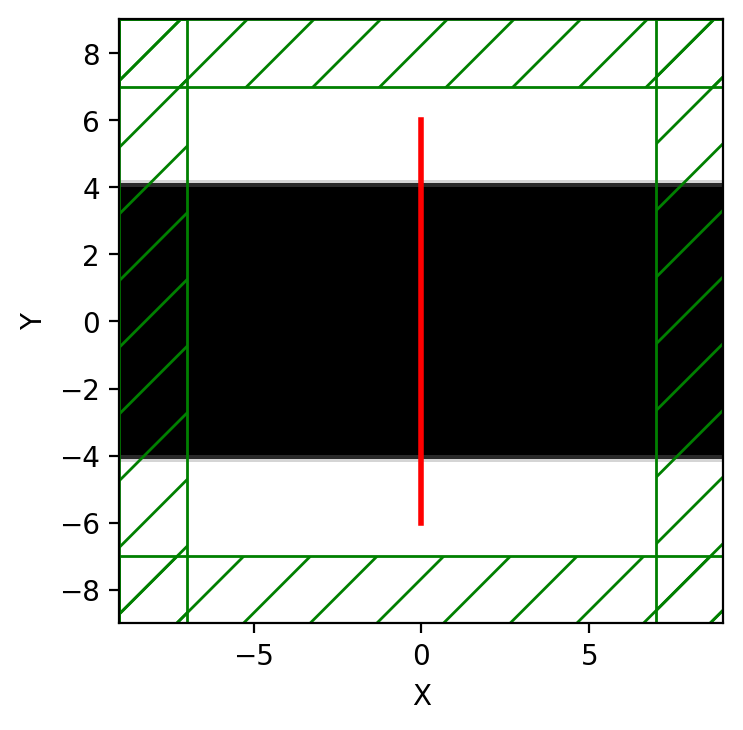

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(dpi=200)
sim.plot2D(plot_sources_flag=True,plot_monitors_flag=True,eps_parameters={'interpolation':'none'})
plt.show()

In [ ]:
num_tols = 1
tols = np.power(10, np.arange(-8.0,-8.0-num_tols,-1.0))
ez_dat = np.zeros((142,142,num_tols), dtype=np.complex_)

for i in range(num_tols):
    sim.init_sim()
    sim.solve_cw(tols[i], 10000, 10)
    ez_dat[:,:,i] = sim.get_array(vol=nonpml_vol, component=mp.Ez)

err_dat = np.zeros(num_tols-1)
for i in range(num_tols-1):
    err_dat[i] = LA.norm(ez_dat[:,:,i]-ez_dat[:,:,num_tols-1])

#plt.figure(dpi=150)
#plt.loglog(tols[:num_tols-1], err_dat, 'bo-');
#plt.xlabel("frequency-domain solver tolerance");
#plt.ylabel("L2 norm of error in fields");
#plt.show()

eps_data = sim.get_array(vol=nonpml_vol, component=mp.Dielectric)
ez_data = np.real(ez_dat[:,:,num_tols-1])

plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

if np.all(np.diff(err_dat) < 0):
    print("PASSED solve_cw test: error in the fields is decreasing with increasing resolution")
else:
    print("FAILED solve_cw test: error in the fields is NOT decreasing with increasing resolution")
